# PhageHostLearn - v3.1 (Klebsiella)

An AI-based Phage-Host interaction prediction framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages. This notebook follows after having ran the PhageHostLearn_processing steps implemented in the accompanying Jupyter notebook.

**Architecture of this framework**: 
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance) 
- Either language embeddings for amino acids that constitute the building blocks for HDC
- OR random initialization of amino acid tokens
- Convolutional vector embeddings for both sets of proteins that are bound
- train an RF model on the embeddings and do binary classification

**Overview of the notebook**:

1. [Defining the necessary functions](#functions)
2. [Transform the loci sequences into embeddings](#lociembed) using hyperdimensional vectors
3. [Transform the RBP sequences into embeddings](#rbpembed) using hyperdimensional vectors
4. [Compute joint features by binding](#joint)
5. [RF](#machinelearning)

## 0 - Libraries and directories

In [1]:
using CSV
using MLJ
using Test
using JSON
using Plots
using FASTX
using MLBase
using Colors
using Random
using XGBoost
using StatsBase
using StatsPlots
using Statistics
using DataFrames
using ScikitLearn
using EvalMetrics
using BioAlignments
using ProgressMeter
using LinearAlgebra
using ProgressMeter
using BioAlignments
using DelimitedFiles
using MultivariateStats
using ScikitLearn.Pipelines: Pipeline
using ScikitLearn.CrossValidation: train_test_split
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn.Skcore: make_scorer

@sk_import decomposition: PCA
@sk_import ensemble: RandomForestClassifier
@sk_import metrics: roc_auc_score

push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing

general_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data" # general directory
results_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models"
data_suffix = "Valencia"; # choose a suffix for the created data files

## 1 - Functions<a name="functions"></a>

#### Hyperdimensional computing

In [2]:
function hd_vectorization(sequence, tokens; layers=3, k=(6, 6, 6))
    """
    Convolutional sequence vectorization with hyperdimensional vectors.
    
    Inputs:
    - sequence: the sequence to embed
    - tokens: the starting tokens to begin from, a dictionary {token->hyperdimensional_vector}
    - layers: how many convolutional layers to embed with
    - k: the sliding window for each of the convolution, should correspond to # layers
    
    Output: 
    a vector that represents the 'embedded' sequence
    
    To do: add padding and strides? add check: min length sequence.
    """
    # preprocess the tokens (layer 0)
    sequence_hdvs = [tokens[item] for item in sequence]
    
    # do convolutions
    for layer in 1:layers
        layer_hdvs = []
        layer_k = k[layer]
        for i in 1:length(sequence_hdvs)-layer_k+1
            # select sliding window
            window = sequence_hdvs[i:i+layer_k-1]
            # shift the hdvs
            shifted_hdvs = [circshift(window[j], layer_k-j) for (j, item) in enumerate(window)]
            # bind the hdvs
            push!(layer_hdvs, HyperdimensionalComputing.bind(shifted_hdvs))
        end
        # update sequence hdvs
        sequence_hdvs = layer_hdvs
    end
    return HyperdimensionalComputing.aggregate(convert(Vector{BipolarHDV}, sequence_hdvs))
end

hd_vectorization (generic function with 1 method)

In [3]:
function convolved_embedding(sequence, tokens, k=3)
    """
    Simple 2-layer convolved embedding in hyperdimensional space
    """
    # layer 1
    kmer_hdvs = []
    for i in 1:length(sequence)-k+1
        kmer = sequence[i:i+k-1]
        aa_hdvs = [circshift(tokens[aa], k-l) for (l, aa) in enumerate(kmer)]
        push!(kmer_hdvs, HyperdimensionalComputing.bind(aa_hdvs))
    end
    
    # layer 2
    conv_kmer_hdvs = []
    for i in 1:length(kmer_hdvs)-k+1
        convolved_kmers = kmer_hdvs[i:i+k-1]
        conv_hdvs = [circshift(convolved_kmers[l], k-l) for (l, km) in enumerate(convolved_kmers)]
        push!(conv_kmer_hdvs, HyperdimensionalComputing.bind(conv_hdvs))
    end
    
    return HyperdimensionalComputing.aggregate(convert(Vector{BipolarHDV}, conv_kmer_hdvs))
end

convolved_embedding (generic function with 2 methods)

##### Other

In [4]:
function file_to_array(file)
    """
    Function that reads a FASTA file and puts its sequences in an array.
    """
    sequences = []
    reader = FASTA.Reader(open(file, "r"))
    for record in reader
        seq = FASTA.sequence(record)
        push!(sequences, seq)
    end
    return sequences
end

file_to_array (generic function with 1 method)

In [5]:
function mean_reciprocal_rank(queries)
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    if isa(queries, Matrix)
        queries_list = [queries[i,:] for i in 1:size(queries)[1]]
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries_list]
    else
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries]
    end
    return mean(reciprocal_ranks)
end

mean_reciprocal_rank (generic function with 1 method)

In [6]:
function recallatk(queries, k)
    """
    recall at top K for binary problems. Relevant items should be labeled as 1.
    
    Input: 
    - queries: list of lists of queries that are sorted (i.e. true labels sorted by prediction score)
    - k: the top you want to look at
    """
    recalls_k = []
    for query in queries
        if k > length(query)
            k = length(query)
        end   
        push!(recalls_k, sum(query[1:k] .== 1) / sum(query .== 1))
    end
    return mean(recalls_k)
end

recallatk (generic function with 1 method)

In [7]:
function hitratio(queries, k)
    """
    hit ratio for in the first k elements (sorted queries)
    """
    hitratios = []
    for query in queries
        if k > length(query)
            k = length(query)
        end
        
        if sum(query[1:k]) > 0
            push!(hitratios, 1)
        end
    end
    return sum(hitratios) / length(queries)
end

hitratio (generic function with 1 method)

## 1b - Create AA tokens from language embeddings or randomly

Het tegenargument bij starten vanuit de volledige RBPs is dat enkel de globale similariteiten behouden blijven bij matrix vermenigvuldiging, en er gaat wat info verloren door bipolair maken erna. Als we starten vanop het AA niveau, dan hebben we alleen maar lokale informatie (globaal = lokaal). En we transformeren opnieuw naar bipolair dus verliezen wel wat informatie maar er blijft nog steeds meer informatie ingebakken vergeleken met random!

In [8]:
# OR alphabet randomly
alphabet = "GAVLIFPSTYCMKRHWDENQX"
tokens = Dict(c=>BipolarHDV() for c in alphabet);

## 2 - Computing loci embeddings<a name="lociembed"></a>

In this section, we define hyperdimensional vectors for the amino-acid alphabet and use these hyperdimensional vectors to construct *hyperdimensional embeddings* for our loci proteins. For the loci proteins, this is a multi-instance setting: multiple proteins will be embedded into hyperdimensional space and then those vectors are aggregated to form one final vector for each locus.

In [9]:
# load data
LociBase = JSON.parsefile(general_dir*"/Locibase"*data_suffix*".json")
seros = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"));

In [10]:
# compute loci embeddings w/ proteins (multi-instance)
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [hd_vectorization(string(sequence), tokens, layers=2, k=(6,6)) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

## 3 - Computing RBP embeddings<a name="rbpembed"></a>

We combine the vectors for each phage's RBP(s), also a multi-instance setting

In [11]:
# load data
RBPbase = DataFrame(CSV.File(general_dir*"/RBPbase"*data_suffix*".csv"));

In [12]:
# compute single-rbp embeddings
single_rbp_embeddings = [hd_vectorization(string(sequence), tokens, layers=2, k=(6,6)) for sequence in RBPbase.protein_sequence]

# put the signatures in a matrix for sklearn
single_rbp_matrix = zeros(Int64, length(single_rbp_embeddings), 10000)
for (i, embedding) in enumerate(single_rbp_embeddings)
    single_rbp_matrix[i,:] = embedding
end
single_rbp_embeddings = hcat(DataFrame(name=RBPbase.phage_ID), DataFrame(single_rbp_matrix, :auto));

In [13]:
# compute multi-rbp embeddings
rbp_embeddings = Array{BipolarHDV}(undef, length(unique(RBPbase.phage_ID)))
for (i, phageid) in enumerate(unique(RBPbase.phage_ID))
    subset = filter(row -> row.phage_ID == phageid, RBPbase)
    protein_hdvs = [hd_vectorization(string(sequence), tokens, layers=2, k=(6,6)) for sequence in subset.protein_sequence]
    multirbp_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    rbp_embeddings[i] = multirbp_hdv
end

## 4 - Compute joint feature representations and make dataframe for training<a name="joint"></a>

In [14]:
IM = DataFrame(CSV.File(general_dir*"/phage_host_interactions"*data_suffix*".csv"))
rename!(IM,:Column1 => :Host)
interaction_matrix = Matrix(IM[1:end, 2:end])
#loci_names = IM.accession
#serotypes = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"))
#rbp_names = names(IM)[2:end];

In [15]:
# compute sigatures for loci x RBP embeddings by BINDING
features_bind = []
labels = []
groups_loci = []
groups_phage = []
for (i, accession) in enumerate(collect(keys(LociBase)))
    for (j, phage_id) in enumerate(unique(RBPbase.phage_ID))
        subset = filter(row -> row.Host == accession, IM)
        interaction = subset[!, phage_id][1]
        if isequal(interaction, 1) || isequal(interaction, 0)
            signature = HyperdimensionalComputing.bind([loci_embeddings[i], rbp_embeddings[j]])
            push!(features_bind, signature)
            push!(labels, trunc(Int, interaction))
            push!(groups_loci, i)
            push!(groups_phage, j)
        end
    end
end

In [16]:
# put the signatures in a matrix for sklearn
features_b = zeros(Int64, length(features_bind), 10000)
for i in range(1, length=length(features_bind))
    features_b[i,:] = features_bind[i]
end

## 5 - RF K-fold evaluation<a name="machinelearning"></a>

In [150]:
# shuffle and set test set aside
X_train, X_test, y_train, y_test = train_test_split(features_b, labels, test_size=0.2, stratify=labels);

In [151]:
# define model and CV
rf = RandomForestClassifier(class_weight="balanced", n_jobs=6)
params = Dict("n_estimators"=>[500, 750, 1000, 1250], "max_depth"=>[3, 5, 7, 9])
cv = CrossValidation.StratifiedKFold(y_train, n_folds=5, shuffle=true, random_state=42);

In [152]:
# do hyperparameter tuning
rocauc = make_scorer(roc_auc_score)
rf_tuned = GridSearchCV(rf, params, cv=cv, scoring=rocauc, verbose=3)
ScikitLearn.fit!(rf_tuned, X_train, y_train)
println(rf_tuned.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] n_estimators=500, max_depth=3
[CV] n_estimators=500, max_depth=3, score=0.77392  -  2.3s
[CV] n_estimators=500, max_depth=3
[CV] n_estimators=500, max_depth=3, score=0.73212  -  2.1s
[CV] n_estimators=500, max_depth=3
[CV] n_estimators=500, max_depth=3, score=0.69459  -  2.2s
[CV] n_estimators=500, max_depth=3
[CV] n_estimators=500, max_depth=3, score=0.70903  -  2.0s
[CV] n_estimators=500, max_depth=3
[CV] n_estimators=500, max_depth=3, score=0.77712  -  2.0s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.78248  -  2.7s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.72225  -  2.7s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.70479  -  2.8s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.71945  -  2.7s
[CV] n_estimators=750, max_depth=3
[CV] n_estimators=750, max_depth=3, score=0.75661  -  2.7s

In [ ]:
# LANGUAGE HDC: test set evaluation
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight="balanced", n_jobs=6)
model = ScikitLearn.fit!(rf, X_train, y_train)
scores_pos = ScikitLearn.predict_proba(model, X_test)[:,2]
roc_auc_score(y_test, scores_pos)

In [125]:
# save scores for plotting
results = DataFrame(labels=y_test, scores=scores_pos)
CSV.write(results_dir*"/v3.1/hdc_convolved_6-6-6.csv", results)

"/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models/v3.1/hdc_convolved_6-6-3.csv"

In [20]:
# randomized labels
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced")
pca = PCA(n_components=200)
pipe = Pipeline([("pca", pca), ("rf", rf)])
y_shuffled = shuffle(y_train)
model = ScikitLearn.fit!(pipe, X_train, y_shuffled)
scores_pos = ScikitLearn.predict_proba(model, X_test)[:,2]
println(roc_auc_score(y_test, scores_pos))
results = DataFrame(labels=y_test, scores=scores_pos)
CSV.write(results_dir*"/v2.2/hdc_bind_rf_scores_random.csv", results)

0.5316325387869025


"/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models/v2.2/hdc_bind_rf_scores_random.csv"

## 6 - RF in LOGOCV setting

In [167]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight="balanced", n_jobs=6)
noauc_scores = []
rocauc_scores = []
prauc_scores = []
sero_groups = []
ranked_q = []
p = Progress(200)

for item in unique(groups_loci)
    # define training and test data
    x_train = features_b[groups_loci .!= item, :]
    y_train = labels[groups_loci .!= item]
    x_test = features_b[groups_loci .== item, :]
    y_test = labels[groups_loci .== item]
    
    # train the model
    model = ScikitLearn.fit!(rf, x_train, y_train)
    
    # make predictions and keep the scores
    scores_pos = ScikitLearn.predict_proba(model, x_test)[:,2]
    try
        roc_auc = roc_auc_score(y_test, scores_pos)
        pr_auc = au_prcurve(convert(Vector{Int64}, y_test), convert(Vector{Float64}, scores_pos))
        push!(rocauc_scores, roc_auc)
        push!(prauc_scores, pr_auc)
        this_sero = seros.sero[item]
        push!(sero_groups, this_sero)
        sorted_query = y_test[sortperm(scores_pos, rev=true)] # sort labels to compute MRR later
        push!(ranked_q, sorted_query)
    catch
        push!(noauc_scores, scores_pos)
    end
    
    # pbar update
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:31:38


In [169]:
# print scores
println("ROC AUC: ", mean(rocauc_scores))
println("PR AUC: ", mean(prauc_scores))
println("MRR: ", mean_reciprocal_rank(ranked_q))
println("Top 10 Recall: ", recallatk(ranked_q, 10))

# save scores for plotting
logo_results = DataFrame(sero=sero_groups, rocauc_scores=rocauc_scores, prauc_scores=prauc_scores, 
                            ranked_queries=ranked_q)
CSV.write(results_dir*"/v3.1/hdc_convolved_6-6_logocv.csv", logo_results);

ROC AUC: 0.8241722679933762
PR AUC: 0.5595060705114836
MRR: 0.6587782066956916
Top 10 Recall: 0.7218972628421451


In [170]:
logo_results = DataFrame(CSV.File(results_dir*"/v3.1/hdc_convolved_6-6_logocv.csv"))
ranked_queries = [eval(Meta.parse(logo_results.ranked_queries[i])) for i in 1:length(logo_results.ranked_queries)]
ks = LinRange(1, 50, 50)
recalls = [recallatk(ranked_queries, trunc(Int, k)) for k in ks]
hits = [hitratio(ranked_queries, trunc(Int, k)) for k in ks]
plot(ks, recalls, lw=2.5, label="Recall", c="#508AA8", legend=:topleft, dpi=400)
plot!(ks, hits, lw=2.5, label="Hit ratio", c="#BA2D0B")
ylims!((0.1, 1))
savefig(results_dir*"/v3.1/hdc_convolved_6-6_logocv_recall_hitratio.png")

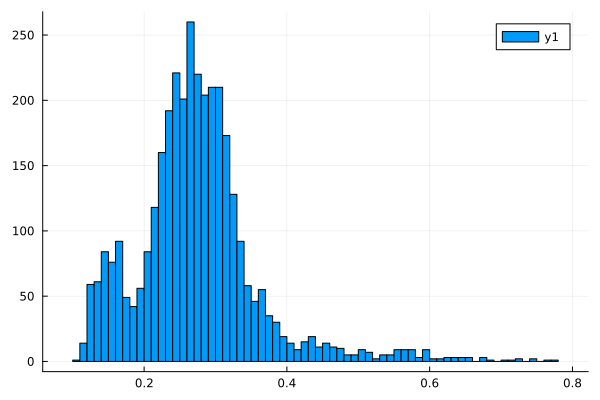

In [84]:
scores_flat = vcat(noauc_scores...)
histogram(scores_flat) # quasi all scores are very low

## 7 - RF single-RBP LOGOCV

In [86]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight="balanced", n_jobs=6)
noauc_scores = []
rocauc_scores = []
prauc_scores = []
sero_groups = []
ranked_q = []
p = Progress(200)

for item in unique(groups_loci)
    # define training and test data
    x_train = features_b[groups_loci .!= item, :]
    y_train = labels[groups_loci .!= item]
    x_test = features_b[groups_loci .== item, :]
    y_test = labels[groups_loci .== item]
    phage_test = groups_phage[groups_loci .== item]
    
    # train the model
    model = ScikitLearn.fit!(rf, x_train, y_train)
    
    # loop over phage RBPs in test set
    scores_pos = []
    this_loci_embedding = loci_embeddings[item]
    for phage_index in phage_test
        # get the correct rbp embeddings
        phageid = unique(RBPbase.phage_ID)[phage_index]
        single_rbp_subset = filter(:name => n -> n == phageid, single_rbp_embeddings)
        
        # make predictions for each single RBP
        rbp_scores = []
        for rbpi in 1:size(single_rbp_subset)[1] # loop over each single rbp embedding
            this_rbp_embedding = BipolarHDV(Vector(single_rbp_subset[rbpi, 2:end]))
            test_signature = HyperdimensionalComputing.bind([this_loci_embedding, this_rbp_embedding])
            test_matrix = zeros(Int64, 1, 10000)
            test_matrix[1,:] = test_signature
            this_score = ScikitLearn.predict_proba(model, test_matrix)[:,2]
            push!(rbp_scores, this_score[1])
        end
        
        # add max score to the list for AUC computing
        push!(scores_pos, maximum(rbp_scores))
    end
    
    # compute ROC & PR AUC
    try
        roc_auc = roc_auc_score(y_test, scores_pos)
        pr_auc = au_prcurve(convert(Vector{Int64}, y_test), convert(Vector{Float64}, scores_pos))
        push!(rocauc_scores, roc_auc)
        push!(prauc_scores, pr_auc)
        this_sero = seros.sero[item]
        push!(sero_groups, this_sero)
        sorted_query = y_test[sortperm(scores_pos, rev=true)] # sort labels to compute MRR later
        push!(ranked_q, sorted_query)
    catch
        push!(noauc_scores, scores_pos)
    end
    
    # pbar update
    next!(p)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:43:08


In [87]:
# print scores
println("ROC AUC: ", mean(rocauc_scores))
println("PR AUC: ", mean(prauc_scores))
println("MRR: ", mean_reciprocal_rank(ranked_q))
println("Top 10 Recall: ", recallatk(ranked_q, 10))

# save scores for plotting
logo_results = DataFrame(sero=sero_groups, rocauc_scores=rocauc_scores, prauc_scores=prauc_scores, 
                            ranked_queries=ranked_q)
CSV.write(results_dir*"/v3.0/hdc_language_aa_singlerbp_logocv_results.csv", logo_results);

ROC AUC: 0.8147233611663354
PR AUC: 0.386437367691892
MRR: 0.5193027014920348
Top 10 Recall: 0.7106674165729283


In [90]:
logo_results = DataFrame(CSV.File(results_dir*"/v3.0/hdc_language_aa_singlerbp_logocv_results.csv"))
ranked_queries = [eval(Meta.parse(logo_results.ranked_queries[i])) for i in 1:length(logo_results.ranked_queries)]
ks = LinRange(1, 46, 46)
recalls = [recallatk(ranked_queries, trunc(Int, k)) for k in ks]
hits = [hitratio(ranked_queries, trunc(Int, k)) for k in ks]
plot(ks, recalls, lw=2.5, label="Recall", c="#508AA8", legend=:topleft, dpi=400)
plot!(ks, hits, lw=2.5, label="Hit ratio", c="#BA2D0B")
ylims!((0.1, 1))
savefig(results_dir*"/v3.0/hdc_language_aa_singlerbp_logocv_recall_hitratio.png")

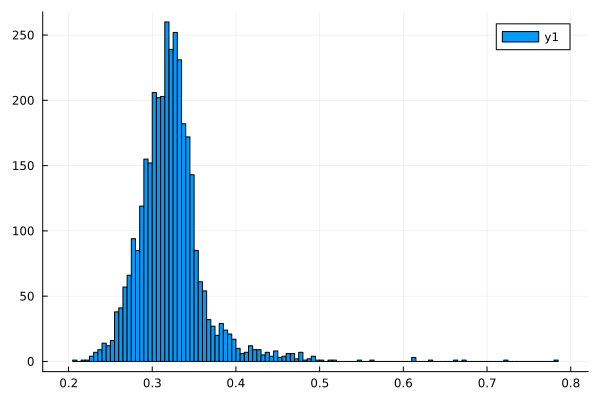

In [89]:
scores_flat = vcat(noauc_scores...)
histogram(scores_flat) # quasi all scores are very low

## 8 - Active learning simulation

1. set some groups_loci aside at random, 
2. then do loocv as usual.
3. compute and save the performance
4. select a new group_withold to add, and add that to groups_loocv
5. then redo the loocv as before. Repeat until no more groups in withold left.
6. once looped all the way, plot the performance per iteration.

In [186]:
# 1. select random subset of bacteria to initially withhold for active learning
loocv = rand(length(unique(groups_loci))) .< 0.75
withold = .! loocv
groups_loocv = unique(groups_loci)[loocv]
initial_groups_withold = unique(groups_loci)[withold];

In [187]:
# initialize stuff
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight="balanced", n_jobs=6)
recall_al = []
hitratio_al = []
groups_withold = deepcopy(initial_groups_withold)

# simulate active learning
while length(groups_withold) > 0
    # 2. do LOOCV
    ranked_q = []
    noauc = 0
    p = Progress(length(groups_loocv))
    println("loocv: ", length(groups_loocv))
    for item in groups_loocv
        selection = [i for (i, loci) in enumerate(groups_loci) if (loci in groups_loocv && loci != item)]
        x_train = features_b[selection, :]
        y_train = labels[selection]
        x_test = features_b[groups_loci .== item, :]
        y_test = labels[groups_loci .== item]
        
        model = ScikitLearn.fit!(rf, x_train, y_train)
        scores_pos = ScikitLearn.predict_proba(model, x_test)[:,2]
        if item ∉ initial_groups_withold # compute performance only for initial set!
            try
                roc_auc = roc_auc_score(y_test, scores_pos)
                sorted_query = y_test[sortperm(scores_pos, rev=true)] # sort labels to compute MRR later
                push!(ranked_q, sorted_query)
            catch
                noauc += 1
            end
        end
        next!(p)
    end
    
    # 3. compute and save performance
    println("queries: ", length(ranked_q))
    println("noauc: ", noauc)
    push!(recall_al, recallatk(ranked_q, 10))
    push!(hitratio_al, hitratio(ranked_q, 10))
    
    # 4. select new bacteria to add
    new_locus = StatsBase.sample(groups_withold)
    push!(groups_loocv, new_locus)
    deleteat!(groups_withold, findall(x->x==new_locus, groups_withold))
    
    println("Finished another round of AL! To go: ", length(groups_withold))
end 

loocv: 151


Progress: 100%|█████████████████████████████████████████| Time: 0:16:45


queries: 94
noauc: 57
Finished another round of AL! To go: 48
loocv: 152


Progress: 100%|█████████████████████████████████████████| Time: 0:17:30


queries: 94
noauc: 57
Finished another round of AL! To go: 47
loocv: 153


Progress: 100%|█████████████████████████████████████████| Time: 0:17:55


queries: 94
noauc: 57
Finished another round of AL! To go: 46
loocv: 154


Progress: 100%|█████████████████████████████████████████| Time: 0:18:27


queries: 94
noauc: 57
Finished another round of AL! To go: 45
loocv: 155


Progress: 100%|█████████████████████████████████████████| Time: 0:18:44


queries: 94
noauc: 57
Finished another round of AL! To go: 44
loocv: 156


Progress: 100%|█████████████████████████████████████████| Time: 0:18:26


queries: 94
noauc: 57
Finished another round of AL! To go: 43
loocv: 157


Progress: 100%|█████████████████████████████████████████| Time: 0:18:55


queries: 94
noauc: 57
Finished another round of AL! To go: 42
loocv: 158


Progress: 100%|█████████████████████████████████████████| Time: 0:19:03


queries: 94
noauc: 57
Finished another round of AL! To go: 41
loocv: 159


Progress: 100%|█████████████████████████████████████████| Time: 0:19:18


queries: 94
noauc: 57
Finished another round of AL! To go: 40
loocv: 160


Progress: 100%|█████████████████████████████████████████| Time: 0:19:43


queries: 94
noauc: 57
Finished another round of AL! To go: 39
loocv: 161


Progress: 100%|█████████████████████████████████████████| Time: 0:20:05


queries: 94
noauc: 57
Finished another round of AL! To go: 38
loocv: 162


Progress: 100%|█████████████████████████████████████████| Time: 0:20:41


queries: 94
noauc: 57
Finished another round of AL! To go: 37
loocv: 163


Progress: 100%|█████████████████████████████████████████| Time: 0:20:37


queries: 94
noauc: 57
Finished another round of AL! To go: 36
loocv: 164


Progress: 100%|█████████████████████████████████████████| Time: 0:20:14


queries: 94
noauc: 57
Finished another round of AL! To go: 35
loocv: 165


Progress: 100%|█████████████████████████████████████████| Time: 0:20:47


queries: 94
noauc: 57
Finished another round of AL! To go: 34
loocv: 166


Progress: 100%|█████████████████████████████████████████| Time: 0:21:24


queries: 94
noauc: 57
Finished another round of AL! To go: 33
loocv: 167


Progress: 100%|█████████████████████████████████████████| Time: 0:21:45


queries: 94
noauc: 57
Finished another round of AL! To go: 32
loocv: 168


Progress: 100%|█████████████████████████████████████████| Time: 0:21:59


queries: 94
noauc: 57
Finished another round of AL! To go: 31
loocv: 169


Progress: 100%|█████████████████████████████████████████| Time: 0:22:11


queries: 94
noauc: 57
Finished another round of AL! To go: 30
loocv: 170


Progress: 100%|█████████████████████████████████████████| Time: 0:22:30


queries: 94
noauc: 57
Finished another round of AL! To go: 29
loocv: 171


Progress: 100%|█████████████████████████████████████████| Time: 0:22:48


queries: 94
noauc: 57
Finished another round of AL! To go: 28
loocv: 172


Progress: 100%|█████████████████████████████████████████| Time: 0:23:04


queries: 94
noauc: 57
Finished another round of AL! To go: 27
loocv: 173


Progress: 100%|█████████████████████████████████████████| Time: 0:23:17


queries: 94
noauc: 57
Finished another round of AL! To go: 26
loocv: 174


Progress: 100%|█████████████████████████████████████████| Time: 0:23:41


queries: 94
noauc: 57
Finished another round of AL! To go: 25
loocv: 175


Progress: 100%|█████████████████████████████████████████| Time: 0:23:43


queries: 94
noauc: 57
Finished another round of AL! To go: 24
loocv: 176


Progress: 100%|█████████████████████████████████████████| Time: 0:24:02


queries: 94
noauc: 57
Finished another round of AL! To go: 23
loocv: 177


Progress: 100%|█████████████████████████████████████████| Time: 0:24:15


queries: 94
noauc: 57
Finished another round of AL! To go: 22
loocv: 178


Progress: 100%|█████████████████████████████████████████| Time: 0:24:37


queries: 94
noauc: 57
Finished another round of AL! To go: 21
loocv: 179


Progress: 100%|█████████████████████████████████████████| Time: 0:24:48


queries: 94
noauc: 57
Finished another round of AL! To go: 20
loocv: 180


Progress: 100%|█████████████████████████████████████████| Time: 0:24:55


queries: 94
noauc: 57
Finished another round of AL! To go: 19
loocv: 181


Progress: 100%|█████████████████████████████████████████| Time: 0:25:09


queries: 94
noauc: 57
Finished another round of AL! To go: 18
loocv: 182


Progress: 100%|█████████████████████████████████████████| Time: 0:25:26


queries: 94
noauc: 57
Finished another round of AL! To go: 17
loocv: 183


Progress: 100%|█████████████████████████████████████████| Time: 0:25:40


queries: 94
noauc: 57
Finished another round of AL! To go: 16
loocv: 184


Progress: 100%|█████████████████████████████████████████| Time: 0:26:09


queries: 94
noauc: 57
Finished another round of AL! To go: 15
loocv: 185


Progress: 100%|█████████████████████████████████████████| Time: 0:26:25


queries: 94
noauc: 57
Finished another round of AL! To go: 14
loocv: 186


Progress: 100%|█████████████████████████████████████████| Time: 0:26:32


queries: 94
noauc: 57
Finished another round of AL! To go: 13
loocv: 187


Progress: 100%|█████████████████████████████████████████| Time: 0:27:00


queries: 94
noauc: 57
Finished another round of AL! To go: 12
loocv: 188


Progress: 100%|█████████████████████████████████████████| Time: 0:26:41


queries: 94
noauc: 57
Finished another round of AL! To go: 11
loocv: 189


Progress: 100%|█████████████████████████████████████████| Time: 0:27:05


queries: 94
noauc: 57
Finished another round of AL! To go: 10
loocv: 190


Progress: 100%|█████████████████████████████████████████| Time: 0:27:18


queries: 94
noauc: 57
Finished another round of AL! To go: 9
loocv: 191


Progress: 100%|█████████████████████████████████████████| Time: 0:27:56


queries: 94
noauc: 57
Finished another round of AL! To go: 8
loocv: 192


Progress: 100%|█████████████████████████████████████████| Time: 0:27:46


queries: 94
noauc: 57
Finished another round of AL! To go: 7
loocv: 193


Progress: 100%|█████████████████████████████████████████| Time: 0:28:24


queries: 94
noauc: 57
Finished another round of AL! To go: 6
loocv: 194


Progress: 100%|█████████████████████████████████████████| Time: 0:28:52


queries: 94
noauc: 57
Finished another round of AL! To go: 5
loocv: 195


Progress: 100%|█████████████████████████████████████████| Time: 0:29:02


queries: 94
noauc: 57
Finished another round of AL! To go: 4
loocv: 196


Progress: 100%|█████████████████████████████████████████| Time: 0:29:38


queries: 94
noauc: 57
Finished another round of AL! To go: 3
loocv: 197


Progress: 100%|█████████████████████████████████████████| Time: 0:29:34


queries: 94
noauc: 57
Finished another round of AL! To go: 2
loocv: 198


Progress: 100%|█████████████████████████████████████████| Time: 0:30:08


queries: 94
noauc: 57
Finished another round of AL! To go: 1
loocv: 199


Progress: 100%|█████████████████████████████████████████| Time: 0:30:38


queries: 94
noauc: 57
Finished another round of AL! To go: 0


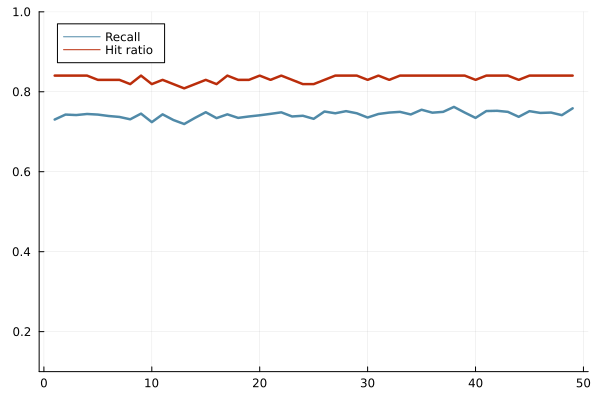

In [189]:
# plot results
ks = LinRange(1, length(recall_al), length(recall_al))
plot(ks, recall_al, lw=2.5, label="Recall", c="#508AA8", legend=:topleft, dpi=400)
plot!(ks, hitratio_al, lw=2.5, label="Hit ratio", c="#BA2D0B")
ylims!((0.1, 1))
#savefig(results_dir*"/v3.1/hdc_convolved_6-6_active_learning.png")

## X - Tests

In [69]:
@testset "tests for MRR" begin
    @test mean_reciprocal_rank([[0, 0, 0], [0, 1, 0], [1, 0, 0]]) == 0.5
    @test mean_reciprocal_rank([[1, 0, 0], [1, 1, 0], [1, 0, 0]]) == 1
    A = [0 0 0; 0 1 0; 1 0 0] # Matrix
    @test mean_reciprocal_rank(A) == 0.5
end;

Test Summary: | Pass  Total
tests for MRR |    3      3


In [19]:
@testset "test for Recall@K" begin
    @test recallatk([[1, 0, 0, 1, 0]], 3) == 0.5
    @test recallatk([[1, 0, 0, 1, 0], [1, 1, 0, 0, 0]], 3) == 0.75
end;

Test Summary:     | Pass  Total
test for Recall@K |    2      2


In [51]:
@testset "tests for constructing relevant matrix" begin
    preds = [0 0 1; 1 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == labels # all TPs
    preds = [0 0 0; 1 0 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 0 0; 0 0 0] # missed TPs
    preds = [0 1 0; 1 1 0; 1 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 1 0; 0 0 0] # FPs
end;

Test Summary:                          | Pass  Total
tests for constructing relevant matrix |    3      3
